In [93]:
import pandas as pd

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [94]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [95]:
drop_columns = [
    "PassengerId",
    "Name",
    "Ticket",
    "Fare",
    "Cabin"
]
train_data.drop(columns=drop_columns , inplace=True , axis=1)
test_data.drop(columns=drop_columns , inplace=True , axis= 1)

In [96]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Embarked  889 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 48.9+ KB


In [97]:
mode_value = train_data["Embarked"].mode()[0]
median_value = train_data["Age"].median()
train_data["Embarked"] = train_data["Embarked"].fillna(mode_value)
train_data["Age"] = train_data["Age"].fillna(median_value)

In [98]:
#Feature Engineering
import numpy as np
train_data["Age_category"] = pd.cut(train_data['Age'],
                                    bins=[0 , 12 , 18,  60 , 80],
                                    labels=['Child' , "Teen" , "Middle-Aged" , "Old"])

test_data["Age_category"] = pd.cut(test_data['Age'],
                                    bins=[0 , 12 , 18,  60 , 80],
                                    labels=['Child' , "Teen" , "Middle-Aged" , "Old"])

train_data["Age_Sex_Protocol"] = train_data["Age_category"].astype(str) + "_" + train_data["Sex"].astype(str)
test_data["Age_Sex_Protocol"] = test_data["Age_category"].astype(str) + "_" + test_data["Sex"].astype(str)



In [99]:
from sklearn.preprocessing import LabelEncoder
objects = ["Sex" , "Embarked","Age_category","Age_Sex_Protocol"]
for feature in objects:
    le = LabelEncoder()
    combined = pd.concat([train_data[feature] , test_data[feature]] , axis=0).astype(str)
    le.fit(combined)
    train_data[feature] = le.transform(train_data[feature].astype(str))
    test_data[feature] = le.transform(test_data[feature].astype(str))



In [100]:
#Mutual Information
from sklearn.feature_selection import mutual_info_classif
x_train = train_data.drop(["Survived"] , axis=1)
y_train = train_data["Survived"]

mi_score = mutual_info_classif(x_train , y_train , random_state=42)
mi_scores = pd.DataFrame({
    "Colums" : x_train.columns,
    "Mi_scores" : mi_score
}).sort_values("Mi_scores" , ascending=False)
print(mi_scores)

             Colums  Mi_scores
7  Age_Sex_Protocol   0.167851
1               Sex   0.133217
0            Pclass   0.062738
3             SibSp   0.050577
2               Age   0.026548
4             Parch   0.017025
6      Age_category   0.006899
5          Embarked   0.003226


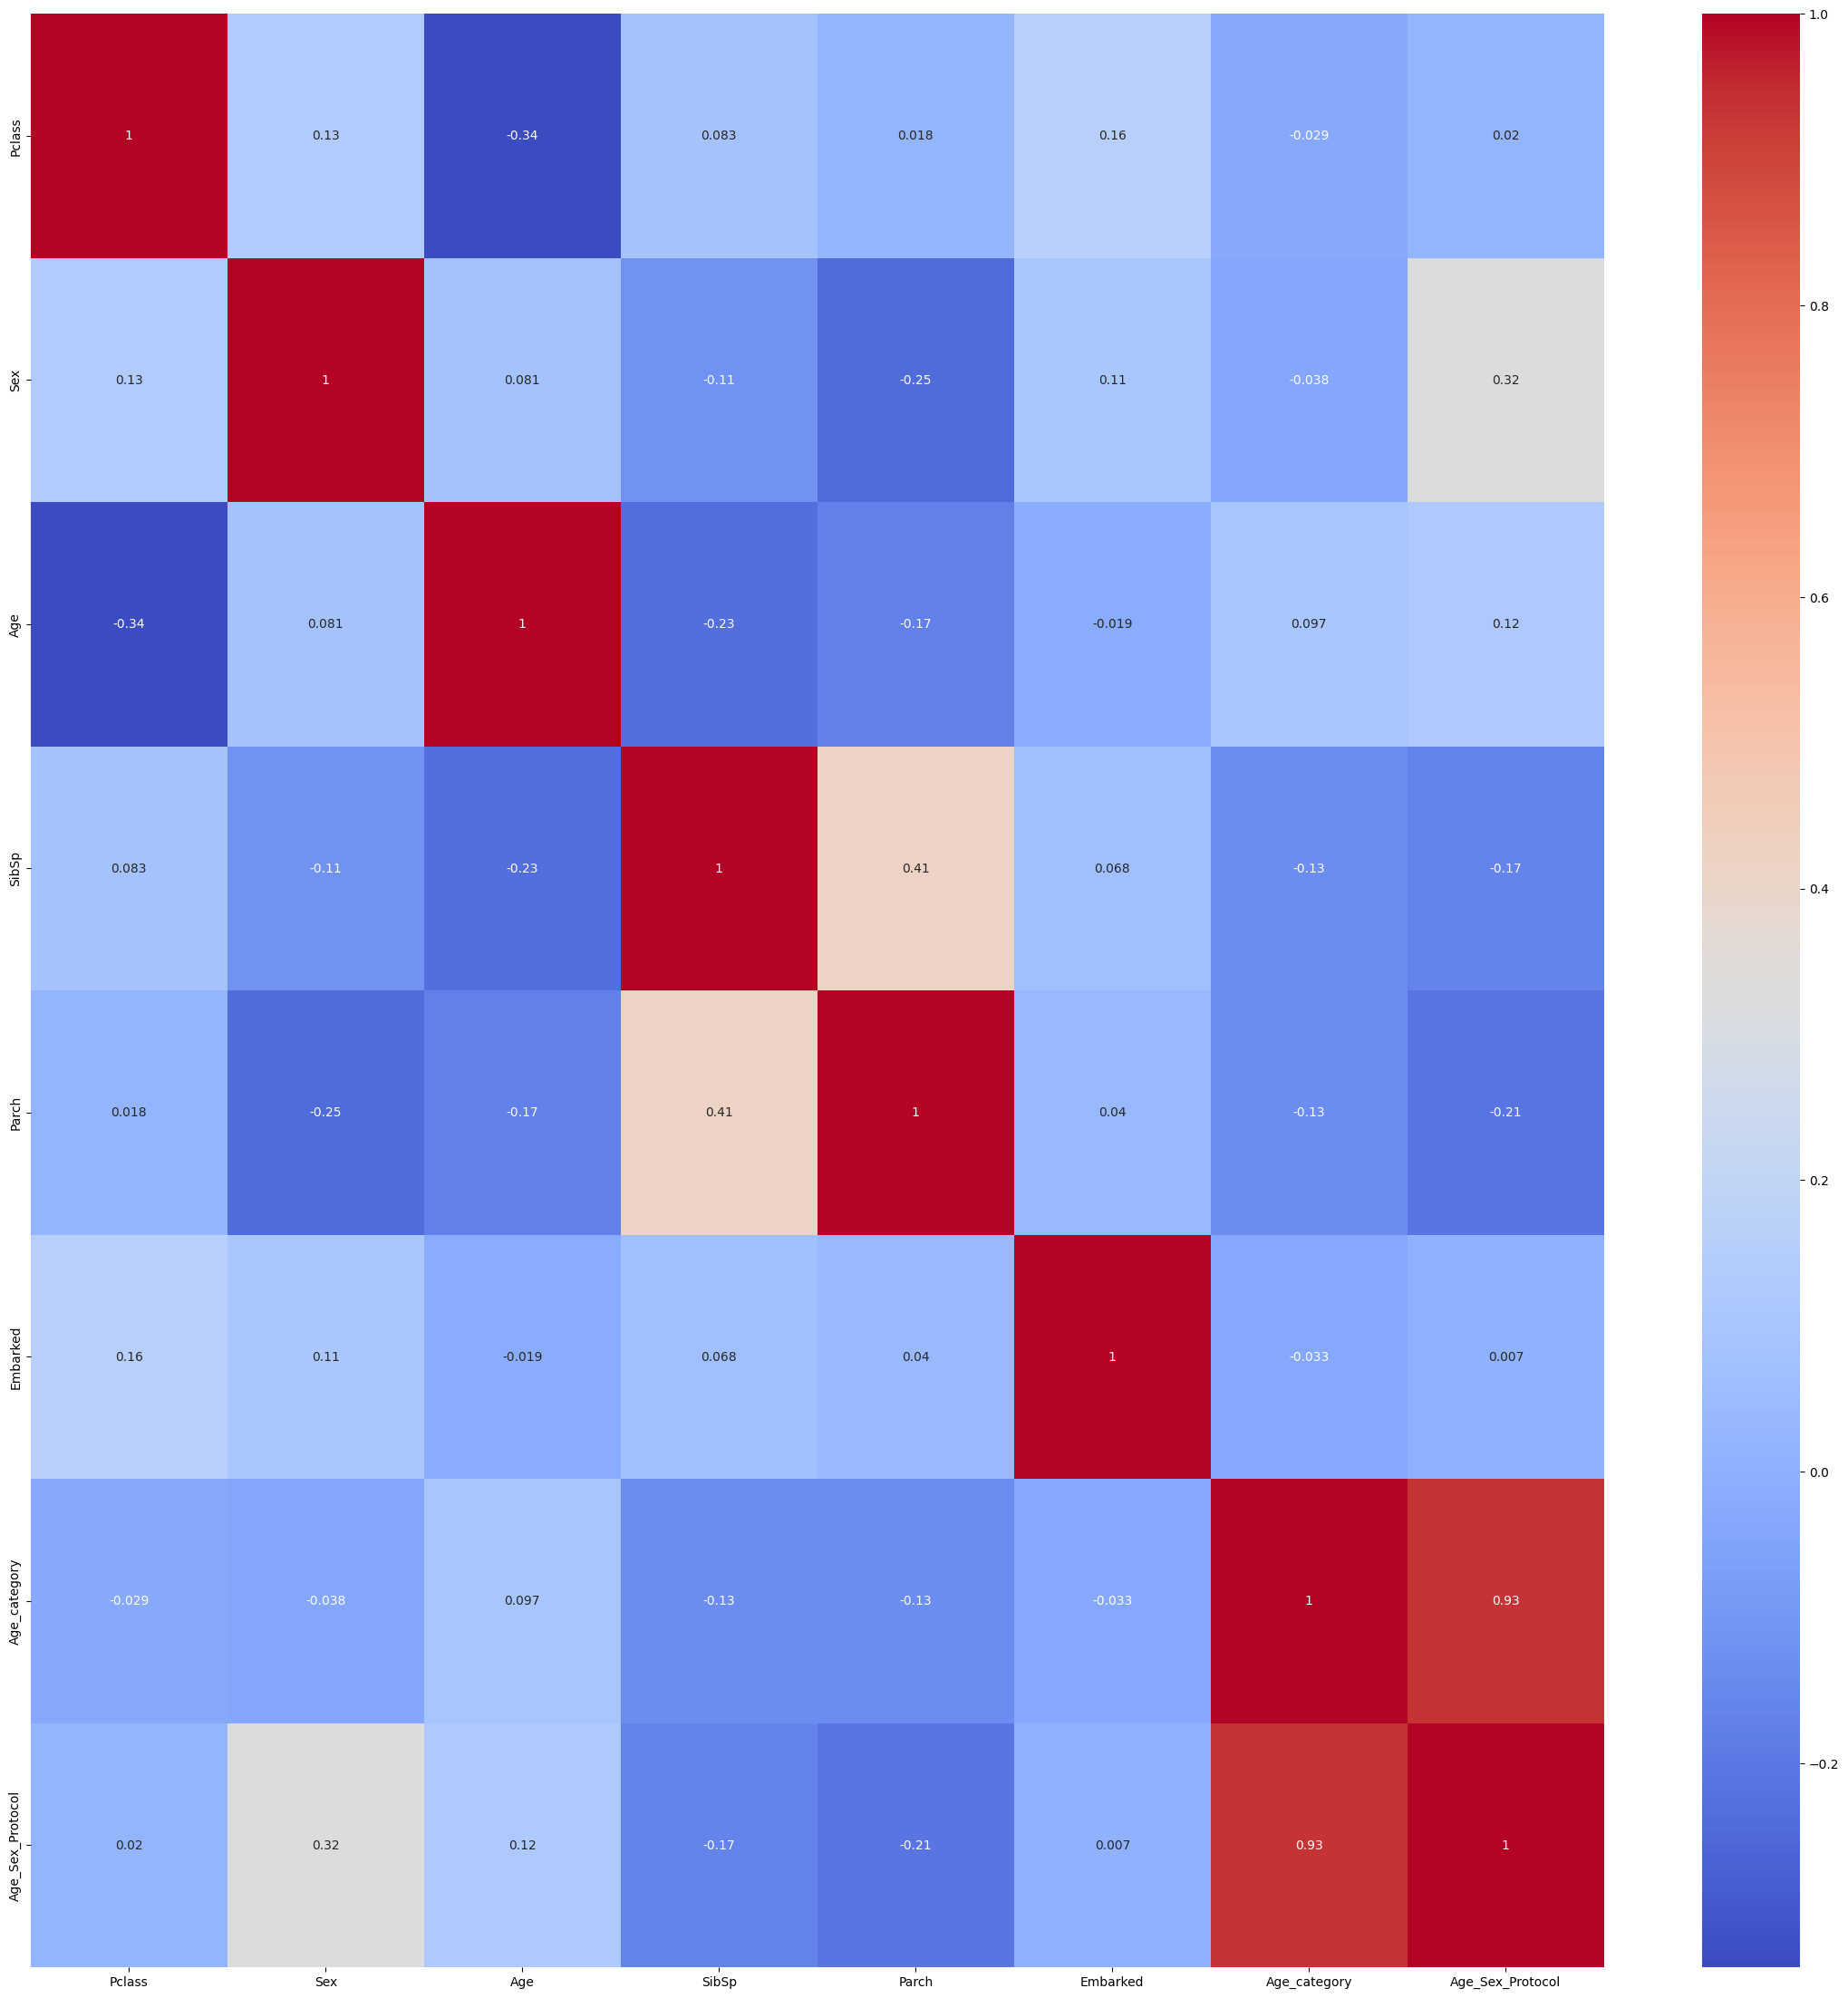

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = x_train.corr()
plt.figure(figsize=(28 , 28))
sns.heatmap(corr_matrix  , annot=True , cmap="coolwarm")
plt.show()

In [105]:
from xgboost import XGBClassifier

model_baseline = XGBClassifier(
    n_estimators=100,  # Fixed typo
    max_depth=5,  # Slightly deeper
    min_child_weight=1,  # Less restrictive
    scale_pos_weight=1.6,  # Adjusted for actual imbalance
    colsample_bytree=0.7,  # This is fine
    learning_rate=0.1,  # Consider adding this
    subsample=0.8,  # Consider adding this
    random_state=42,
    n_jobs=-1
)

model_baseline.fit(x_train , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

In [106]:
from sklearn.metrics import roc_auc_score , classification_report , confusion_matrix

y_pred = model_baseline.predict(x_train)
y_pred_proba = model_baseline.predict_proba(x_train)[: , 1]
print(confusion_matrix(y_train , y_pred))
print(classification_report(y_train , y_pred))
print(roc_auc_score(y_train , y_pred_proba))


[[491  58]
 [ 50 292]]
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       549
           1       0.83      0.85      0.84       342

    accuracy                           0.88       891
   macro avg       0.87      0.87      0.87       891
weighted avg       0.88      0.88      0.88       891

0.9387136633325877


In [107]:
test_prediction = model_baseline.predict(test_data)
test_data_1 = pd.read_csv("test.csv")

submisson = pd.DataFrame({
    "PassengerId" : test_data_1["PassengerId"],
    "Survived" : test_prediction
})
submisson.to_csv("submisson.csv" , index=False)